In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import torch.utils.data

/home/sushlok/anaconda3/envs/fyp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def read_dataset(data_root, mode):
    """
    Read dataset from data_root.
    """
    if mode == 'train':
        # list all sequence folders in train dir
        path = os.path.join(data_root, 'train')
        seq_list = os.listdir(path)
        
    elif mode == 'test':
        path = os.path.join(data_root, 'test')
        seq_list = os.listdir(path)
    else:
        raise ValueError('Invalid mode: {}'.format(mode))
    
    dataset = {}
    seq_lens = {}
    for seq in seq_list:
        seq_root = os.path.join(path, seq)
        img_list = os.listdir(seq_root)
        img_list = [os.path.join(seq_root, img) for img in img_list]
        img_list.sort()
        
        dataset[seq] = img_list
        seq_lens[seq] = len(img_list)
    
    return dataset, seq_lens
    
    
    

In [4]:
# test sample
dataset = read_dataset(r"C:\Users\Machine Learning GPU\Desktop\GOPRO_Large_all(2)", 'train')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Machine Learning GPU\\Desktop\\GOPRO_Large_all(2)/train'

In [8]:
from torch.utils.data import Dataset
from PIL import Image

class Gopro(Dataset):
    def __init__(self, data_root, transform, seq_len = [5,20], speed_range=[1, 10],train=True, mode='train'):
        # Set arguments
        self.data_root = data_root
        self.max_seq_len = seq_len[-1]
        self.min_seq_len = seq_len[0]
        self.speed_range = speed_range
        self.train = train
        self.transform = transform
        assert mode in ['train', 'test'], 'Must be \'train\' or \'test\'.'
        self.mode = mode

        # Read dataset
        self.raw_data, self.seq_lens = read_dataset(self.data_root, self.mode)
        self.seq = list(self.raw_data.keys())
        self.total_imgs = 0
        for i in range(len(self.seq)):
            self.total_imgs += self.seq_lens[self.seq[i]] 
        # print(self.total_imgs)
            
    def __len__(self):
        return self.total_imgs*(self.max_seq_len - self.max_seq_len + 1)*(self.speed_range[-1] - self.speed_range[0] + 1)
        
    def __getitem__(self, idx):
        idx = idx%self.total_imgs
        print(idx)
        seq_num = 0
        while(idx - self.seq_lens[self.seq[seq_num]] >= 0):
            idx = idx - self.seq_lens[self.seq[seq_num]]
            seq_num += 1
        seq = self.seq[seq_num]
        # print(seq)
        speed = np.random.randint(low = self.speed_range[0], high=self.speed_range[-1]+1)
        self.speed = speed
        
        self.seq_gen = np.random.randint(low = self.min_seq_len, high = self.max_seq_len+1)
        
        self.image_list = []
        
        if(idx + self.seq_gen*speed >= self.seq_lens[seq]):
            idx = self.seq_lens[seq] - self.seq_gen*speed - 1
            
        for i in range(self.seq_gen):
            # read image from path
            img_path = self.raw_data[seq][idx + i*speed]
            img = Image.open(img_path)
            
            self.image_list.append(self.transform(img))
        
        # adding zero_padding
        for i in range(self.seq_gen, self.max_seq_len):
            self.image_list.append(torch.zeros_like(self.image_list[0]))
         
         
        # create corresponding blurr image
        blurry_image = 0
        for i in range(self.seq_gen*speed):
            img_path = self.raw_data[seq][idx + i]
            blurry_image = blurry_image + np.asarray(Image.open(img_path))/(self.seq_gen*speed)
        # blurry_image = blurry_image
        self.blurry_image = Image.fromarray(np.uint8(blurry_image))
        
        # Pack data
        data = {
            'speed': torch.tensor(self.speed),
            'length': torch.tensor(self.seq_gen),
            'blur': self.transform(self.blurry_image),
            'gen_seq': self.image_list
        }
        print("speed: ", torch.tensor(self.speed))
        print("length: ", torch.tensor(self.seq_gen))
        print("blur: ", self.transform(self.blurry_image).shape)
        print("gen_seq: ", len(self.image_list))
        
        return data


In [9]:
torch.backends.cudnn.benchmark  = True

In [10]:
# define training data transform

transform =  transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        
    ]
)


In [11]:
trainset = Gopro(r"/home/sushlok/fyp/dataset/GOPRO_Large_all(2)", transform, seq_len = [4,12], speed_range=[1, 4],train=True, mode='train')
testset = Gopro(r"/home/sushlok/fyp/dataset/GOPRO_Large_all(2)", transform, seq_len = [4,12], speed_range=[1, 4],train=False, mode='test')

In [12]:
print(len(trainset))

2800


In [13]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [14]:
dataiter = iter(trainloader)
data = dataiter.next()
images = data['gen_seq']
blurry_image = data['blur']
speed = data['speed']
length = data['length'] 

# print data
# for i, data in enumerate(trainloader):
#     print(data['speed'])
#     print(data['length'])
#     print(data['blur'].shape)
#     print(len(data['gen_seq']))
#     break




198
speed:  tensor(1)
length:  tensor(10)
blur:  torch.Size([3, 256, 256])
gen_seq:  12
541
speed:  tensor(4)
length:  tensor(11)
blur:  torch.Size([3, 256, 256])
gen_seq:  12
443
speed:  tensor(1)
length:  tensor(11)
blur:  torch.Size([3, 256, 256])
gen_seq:  12
298
speed:  tensor(3)
length:  tensor(8)
blur:  torch.Size([3, 256, 256])
gen_seq:  12


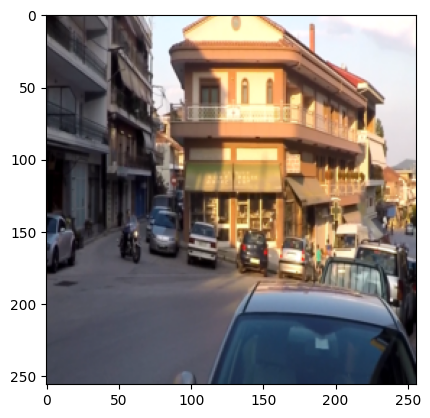

In [15]:
plt.imshow(images[0][0].permute(1,2,0)*0.5 + 0.5)
plt.show()

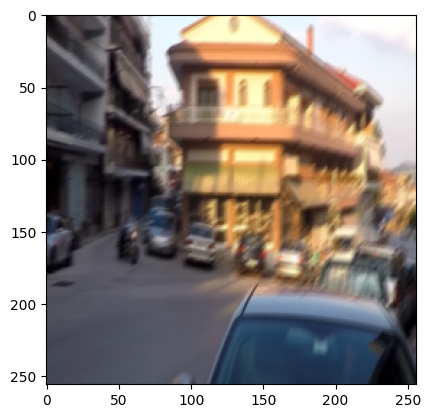

In [16]:
plt.imshow(blurry_image[0].permute(1,2,0)*0.5 + 0.5)
plt.show()

In [17]:
print(speed)

tensor([1, 4, 1, 3])


In [18]:
print(length)

tensor([10, 11, 11,  8])


# modules for video generations

### for encoding and decoding for clear image

In [19]:
# feature extractor model
class conv_encoder(nn.Module):
    def __init__(self, nin, nout, maxpool=True):
        super(conv_encoder, self).__init__()
        self.conv_block = nn.Sequential(
                nn.Conv2d(nin, nout, 3, 1, 1),
                nn.BatchNorm2d(nout),
                nn.LeakyReLU(0.2, inplace=True),
                )
        self.maxpool = nn.MaxPool2d(2, 2)
    

    def forward(self, input):
        if self.maxpool:
            return self.maxpool(self.conv_block(input))
        else:
            return self.conv_block(input)
    
class ResnetBlock(nn.Module):
    def __init__(self, in_channels, kernel_size=3, dilation=[1,1], bias=True):
        super(ResnetBlock, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=1, dilation=dilation[0], padding=((kernel_size-1)//2)*dilation[0], bias=bias),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=1, dilation=dilation[1], padding=((kernel_size-1)//2)*dilation[1], bias=bias),
        )
    
    def forward(self, x):
        out = self.stem(x) + x
        return out


class encoder(nn.Module):
    def __init__(self, output_channels, input_channels, resblocks = True) -> None:
        super(encoder, self).__init__()
        out_ch = 64
        self.conv1 = conv_encoder(input_channels,out_ch) #/2
        self.resblock11 = ResnetBlock(out_ch, kernel_size=3)
        self.resblock12 = ResnetBlock(out_ch, kernel_size=3)
        self.resblock13 = ResnetBlock(out_ch, kernel_size=3)
        
        self.conv2 = conv_encoder(out_ch, out_ch*2) #/4
        self.resblock21 = ResnetBlock(out_ch*2, kernel_size=3)
        self.resblock22 = ResnetBlock(out_ch*2, kernel_size=3)
        self.resblock23 = ResnetBlock(out_ch*2, kernel_size=3)
        
        self.conv3 = conv_encoder(out_ch*2, out_ch*4) #/8
        self.resblock31 = ResnetBlock(out_ch*4, kernel_size=3)
        self.resblock32 = ResnetBlock(out_ch*4, kernel_size=3)
        self.resblock33 = ResnetBlock(out_ch*4, kernel_size=3)
        
        self.conv4 = conv_encoder(out_ch*4, output_channels) #/16
        self.resblock41 = ResnetBlock(output_channels, kernel_size=3)
        self.resblock42 = ResnetBlock(output_channels, kernel_size=3)
        self.resblock43 = ResnetBlock(output_channels, kernel_size=3)
        
        self.resblocks = resblocks
        
    def forward(self, sharp_image):
        if self.resblocks:
            h1 = self.resblock13(self.resblock12(self.resblock11(self.conv1(sharp_image))))
            h2 = self.resblock23(self.resblock22(self.resblock21(self.conv2(h1))))
            h3 = self.resblock33(self.resblock32(self.resblock31(self.conv3(h2))))
            encoding = self.resblock43(self.resblock42(self.resblock41(self.conv4(h3))))
            
        else: 
            h1 = self.conv1(sharp_image)
            h2 = self.conv2(h1)
            h3 = self.conv3(h2)
            encoding = self.conv4(h3)
            
        return encoding, [h1,h2,h3]
  
class conv_decoder(nn.Module):
    def __init__(self,nin, nout) -> None:
        super(conv_decoder, self).__init__()
        self.upconv_block = nn.Sequential(
                nn.ConvTranspose2d(nin, nout, 3, 1, 1),
                nn.BatchNorm2d(nout),
                nn.LeakyReLU(0.2, inplace=True),
                )
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, input):
        return self.upsample(self.upconv_block(input))      
        

class decoder(nn.Module):
    def __init__(self, input_channels, output_channels, resblocks = True) -> None:
        super(decoder, self).__init__()
        out_ch = 64
        self.deconv1 = conv_decoder(input_channels, out_ch*4) #/8
        self.resblock11 = ResnetBlock(out_ch*4, kernel_size=3)
        self.resblock12 = ResnetBlock(out_ch*4, kernel_size=3)
        self.resblock13 = ResnetBlock(out_ch*4, kernel_size=3)
        
        
        self.deconv2 = conv_decoder(out_ch*4, out_ch*2) #/4
        self.resblock21 = ResnetBlock(out_ch*2, kernel_size=3)
        self.resblock22 = ResnetBlock(out_ch*2, kernel_size=3)
        self.resblock23 = ResnetBlock(out_ch*2, kernel_size=3)
        
        self.deconv3 = conv_decoder(out_ch*2, out_ch) #/2
        self.resblock31 = ResnetBlock(out_ch, kernel_size=3)
        self.resblock32 = ResnetBlock(out_ch, kernel_size=3)
        self.resblock33 = ResnetBlock(out_ch, kernel_size=3)
        
        self.deconv4 = conv_decoder(out_ch, output_channels) #/1
        self.resblock41 = ResnetBlock(output_channels, kernel_size=3)
        self.resblock42 = ResnetBlock(output_channels, kernel_size=3)
        self.resblock43 = ResnetBlock(output_channels, kernel_size=3)
        
        self.resblocks = resblocks
        
    
    def forward(self, encoding, catche):
        if self.resblocks:
            d1 = self.resblock13(self.resblock12(self.resblock11(self.deconv1(encoding))))
            d2 = self.resblock23(self.resblock22(self.resblock21(self.deconv2(d1 + catche[2]))))
            d3 = self.resblock33(self.resblock32(self.resblock31(self.deconv3(d2 + catche[1]))))
            d4 = self.resblock43(self.resblock42(self.resblock41(self.deconv4(d3 + catche[0]))))
        
        else:
            d1 = self.deconv1(encoding)
            d2 = self.deconv2(d1 + catche[2])
            d3 = self.deconv3(d2 + catche[1])
            d4 = self.deconv4(d3 + catche[0])
            
        return d4
    

### for encoding motion from blur image

In [20]:
class Corr_Encoder(nn.Module):
    def __init__(self) -> None:
        super(Corr_Encoder).__init__()
        self.softmax = nn.Softmax(dim = 0)

    def forward(self,features):
        N,D,H,W = features.shape
        list_curr_volumes = []
        for i in range(N):
            current_feature = features[0]
            current_feature = current_feature.squeeze().view(D,-1).transpose(1,0)
            corr_volume = torch.corrcoef(current_feature)
            corr_volume = self.softmax(corr_volume)
            corr_volume = corr_volume.reshape(H,W,H,W).unsqueeze(0)
            list_curr_volumes.append(corr_volume)
        
        output = torch.stack(list_curr_volumes)
        N,H,W,H,W = output.shape
        
        return output

### lstm model for p(z|x) for Xt and Xt+1 and for decoding step (not complete)

In [21]:
from torch.autograd import Variable

class lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers, batch_size):
        super(lstm, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.embed = nn.Linear(input_size, hidden_size)
        self.lstm = nn.ModuleList([nn.LSTMCell(hidden_size, hidden_size) for i in range(self.n_layers)])
        self.output = nn.Sequential(
                nn.Linear(hidden_size, output_size),
                #nn.BatchNorm1d(output_size),
                nn.Tanh())
        #self.hidden = self.init_hidden()

    def init_hidden(self, batch_size=1):
        hidden = []
        for i in range(self.n_layers):
            hidden.append((Variable(torch.zeros(batch_size, self.hidden_size).cuda()),
                           Variable(torch.zeros(batch_size, self.hidden_size).cuda())))
        self.hidden = hidden
        return hidden

    def init_hidden_(self, batch_size):
        hidden = []
        for i in range(self.n_layers):
            hidden.append((Variable(torch.zeros(batch_size, self.hidden_size).cuda()),
                           Variable(torch.zeros(batch_size, self.hidden_size).cuda())))
        self.hidden = hidden
        #return hidden

    def forward(self, input):
        embedded = self.embed(input.view(-1, self.input_size))
        h_in = embedded
        for i in range(self.n_layers):
            self.hidden[i] = self.lstm[i](h_in, self.hidden[i])
            h_in = self.hidden[i][0]

        return self.output(h_in)

class gaussian_lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers, batch_size):
        super(gaussian_lstm, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.embed = nn.Linear(input_size, hidden_size)
        self.lstm = nn.ModuleList([nn.LSTMCell(hidden_size, hidden_size) for i in range(self.n_layers)])
        self.mu_net = nn.Linear(hidden_size, output_size)
        self.logvar_net = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()

    def init_hidden(self, batch_size=1):
        hidden = []
        for i in range(self.n_layers):
            hidden.append((Variable(torch.zeros(batch_size, self.hidden_size).cuda()),
                           Variable(torch.zeros(batch_size, self.hidden_size).cuda())))
        self.hidden = hidden
        return hidden

    def init_hidden_(self):
        hidden = []
        for i in range(self.n_layers):
            hidden.append((Variable(torch.zeros(self.batch_size, self.hidden_size).cuda()),
                           Variable(torch.zeros(self.batch_size, self.hidden_size).cuda())))
        self.hidden = hidden
        #return hidden

    def reparameterize(self, mu, logvar):
        logvar = logvar.mul(0.5).exp_()
        eps = Variable(logvar.data.new(logvar.size()).normal_())
        #return eps.add_(mu)
        #return eps.mul(logvar)
        return eps.mul(logvar).add_(mu)

    def forward(self, input):
        #import pdb
        #pdb.set_trace()
        embedded = self.embed(input.view(-1, self.input_size))
        h_in = embedded
        for i in range(self.n_layers):
            self.hidden[i] = self.lstm[i](h_in, self.hidden[i])
            h_in = self.hidden[i][0]
        mu = self.mu_net(h_in)
        logvar = self.logvar_net(h_in)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

### defusion model based p(z|x) modeling for Xt and Xt+1 and for decoding step (future works)

# models for deblurring

### blurred image encoder (same encoder decoder from video generation)

### kernel estimator

In [49]:
class Kernel_estimation(nn.Module):
    def __init__(self,kernel_size, channels) -> None:
        super(Kernel_estimation, self).__init__()
        self.kernel_size = kernel_size
        self.pad = torch.nn.ReplicationPad2d([(self.kernel_size - 1) // 2, (self.kernel_size - 1) // 2, (self.kernel_size - 1) // 2, (self.kernel_size - 1) // 2])
        self.batchnorm = nn.BatchNorm2d(channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, input, kernel):
        N, C, H, W = input.shape
        input = self.pad(input)
        unfolded_input= input.unfold(2,self.kernel_size,1).unfold(3,self.kernel_size,1)
        
        N, C_kernel, H, W = kernel.shape
        kernel = kernel.reshape(N,H,W,-1)
        kernel = kernel.reshape(N,H,W,self.kernel_size,self.kernel_size, -1)
        kernel = kernel.view(N,-1,H,W,self.kernel_size,self.kernel_size)
        # print(kernel.shape, unfolded_input.shape)
        output = kernel*unfolded_input
        output = output.sum(4).sum(4)
        output = self.relu(self.batchnorm(output))
        
        return output
        
        

In [50]:
x = torch.randn(10,64,15,15)
k = torch.randn(10,64*3*3,15,15)
model = Kernel_estimation(3,64)
output = model(x,k)
print(output.shape)

torch.Size([10, 64, 15, 15])


# complete model